In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rosbag
from tqdm import tqdm
import glob, os

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

width = 3.487
height = width / 1.618

def to_time(timestamp):
    return timestamp.secs + 1e-9*timestamp.nsecs

path='/home/dominic/repos/norlab_WMRD/data/husky/'
file='test_1_2022-08-04-09-15-14.bag'

wheelbase=.57

os.chdir(path)
# files = list(glob.glob("*.bag"))
files = [file]

In [16]:
cols = ['t', 'vl', 'omega']

cmd_df = pd.DataFrame(columns=cols)
encoder_df = pd.DataFrame(columns=cols)

for file in tqdm(files):
    bag = rosbag.Bag(file)
    cmd_df_ = pd.DataFrame(columns=cols)

    gen = bag.read_messages(topics=['/doughnut_cmd_vel'])
    msgs = list(gen)
    cmd_df_['t'] = [to_time(msg.timestamp) for msg in msgs]
    cmd_df_['vl'] = [msg.message.linear.x for msg in msgs]
    cmd_df_['omega'] = [msg.message.angular.z for msg in msgs]
    
    cmd_df = pd.concat([cmd_df, cmd_df_], ignore_index=True)
    
for file in tqdm(files):
    bag = rosbag.Bag(file)
    encoder_df_ = pd.DataFrame(columns=cols)

    gen = bag.read_messages(topics=['/husky_velocity_controller/odom'])
    msgs = list(gen)
    encoder_df_['t'] = [to_time(msg.timestamp) for msg in msgs]
    encoder_df_['vl'] = [msg.message.twist.twist.linear.x for msg in msgs]
    encoder_df_['omega'] = [msg.message.twist.twist.angular.z for msg in msgs]
   
    encoder_df = pd.concat([encoder_df, encoder_df_], ignore_index=True)
    

100%|██████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


In [ ]:
cols = ['t', 'v_rf', 'v_rb', 'v_lf', 'v_lb', 'steering', 'angular_v']

autorally_df = pd.DataFrame(columns=cols)

file

for file in tqdm(file):
    bag = rosbag.Bag(files[0])
    df_ = pd.DataFrame(columns=cols)

    gen = bag.read_messages(topics=['/wheelSpeeds'])
    msgs = list(gen)
    df_['t'] = [to_time(msg.timestamp) for msg in msgs]
    df_['v_rf'] = [msg.message.rfSpeed for msg in msgs]
    df_['v_rb'] = [msg.message.rbSpeed for msg in msgs]
    df_['v_lf'] = [msg.message.lfSpeed for msg in msgs]
    df_['v_lb'] = [msg.message.lbSpeed for msg in msgs]

    df_['linear_v'] = .25*(df_['v_rf'] + df_['v_rb'] + df_['v_lf'] + df_['v_lb'])

    gen = bag.read_messages(topics=['/servoStatus'])
    msgs = list(gen)
    steerings = np.zeros((len(df_)))
    
    k=0
    for i in range(len(df_)):
        t = df_.loc[i]['t']
        while k < len(msgs) and to_time(msgs[k].timestamp) < t:
            k+=1
        k-=1
        steerings[i] = msgs[k].message.steering
    df_['steering'] = steerings

    df_['angular_v'] = df_['linear_v'] * np.tan(df_['steering']) / wheelbase

    autorally_df = pd.concat([df, df_], ignore_index=True)

In [17]:
print(cmd_df)
print(encoder_df)

                       t   vl omega
0      1659618916.609733  0.0   0.0
1      1659618916.609813  0.0   0.0
2       1659618916.66015  0.0   0.0
3      1659618916.710219  0.0   0.0
4      1659618916.760212  0.0   0.0
...                  ...  ...   ...
50804  1659621456.810382  0.5   0.0
50805  1659621456.860292  0.4   0.0
50806  1659621456.910014  0.3   0.0
50807  1659621456.960259  0.2   0.0
50808  1659621457.010203  0.1   0.0

[50809 rows x 3 columns]
                       t   vl omega
0      1659618914.377728 -0.0   0.0
1      1659618914.457608 -0.0   0.0
2      1659618914.522147 -0.0   0.0
3      1659618914.569339 -0.0   0.0
4      1659618914.697717 -0.0   0.0
...                  ...  ...   ...
25486  1659621464.081915  0.0  -0.0
25487  1659621464.194063  0.0  -0.0
25488  1659621464.338277  0.0  -0.0
25489  1659621464.401278  0.0  -0.0
25490  1659621464.481602  0.0  -0.0

[25491 rows x 3 columns]


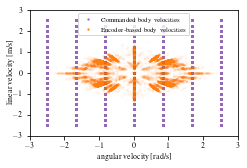

In [24]:
plt.figure(figsize=(10,10))
ax = plt.gca()
fig = plt.gcf()

# print("filtered {} data points".format(len(df)-len(cmd_df)))

max_lv = max(np.abs(cmd_df['vl']))
max_av = max(np.abs(cmd_df['omega']))


cmd = ax.scatter(cmd_df['omega'], cmd_df['vl'], 
                  c = 'tab:purple', 
                  cmap = 'hot', 
                  alpha = 0.05, 
                  lw=0, 
                  s=5,
                  label='Commanded body velocities',
                 rasterized=True)

encoder = ax.scatter(encoder_df['omega'], encoder_df['vl'], 
                  c = 'tab:orange', 
                  cmap = 'hot', 
                  alpha = 0.05, 
                  lw=0, 
                  s=5,
                  label='Encoder-based body velocities',
                 rasterized=True)

ax.set_ylabel('linear velocity [m/s]', labelpad=-2)
ax.set_xlabel('angular velocity [rad/s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

# ax.set_xticks([-1,0,1])
# ax.set_yticks([-1,0,1])
# ax.set_xticklabels([r'$-\dot{\theta}_{max}$', '0', r'$\dot{\theta}_{max}$'])
# ax.set_yticklabels([r'$-v_{max}$', '0', r'$v_{max}$'])

fig.subplots_adjust(left=.15, bottom=.17, right=.98, top=.98)
fig.set_size_inches(width, height)

plt.savefig('/home/dominic/repos/norlab_WMRD/DB/figs/husky_velocities.pdf', dpi=500)

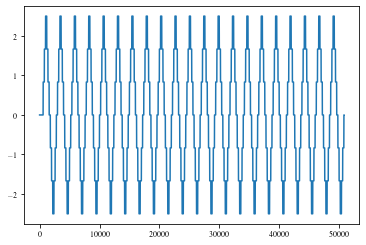

In [19]:
plt.plot(cmd_df['omega'])

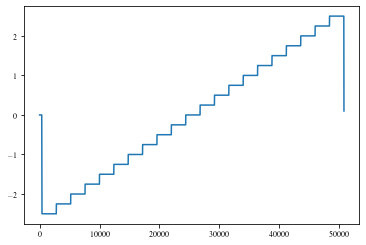

In [20]:
plt.plot(cmd_df['vl'])

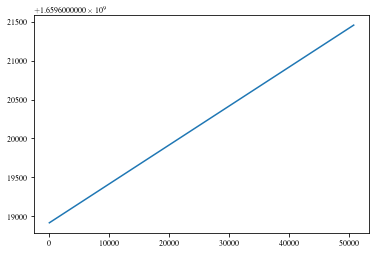

In [21]:
plt.plot(cmd_df['t'])

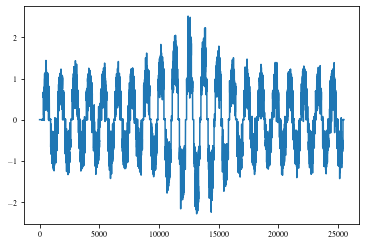

In [22]:
plt.plot(encoder_df['omega'])

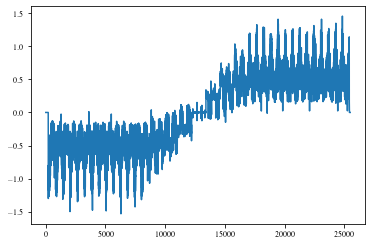

In [23]:
plt.plot(encoder_df['vl'])